<a href="https://colab.research.google.com/github/KC-ai/APPM4600/blob/main/NumericsHW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [22]:
def f(x):
    return 1.0 / (1.0 + x**2)

def fder(x):
    return -2.0 * x / (1.0 + x**2)**2

In [23]:
def lagrange(x_eval, x_nodes, y_nodes):
    N = len(x_nodes) - 1
    L = np.ones(N+1)
    for j in range(N+1):
        for k in range(N+1):
            if k != j:
                L[j] *= (x_eval - x_nodes[k]) / (x_nodes[j] - x_nodes[k])
    return np.sum(y_nodes * L)


In [24]:
def hermite(x_eval, x_nodes, y_nodes, yp_nodes):
    N = len(x_nodes) - 1
    L = np.ones(N+1)
    for j in range(N+1):
        for k in range(N+1):
            if k != j:
                L[j] *= (x_eval - x_nodes[k]) / (x_nodes[j] - x_nodes[k])
    Lp = np.zeros(N+1)
    for j in range(N+1):
        for k in range(N+1):
            if k != j:
                Lp[j] += 1.0 / (x_nodes[j] - x_nodes[k])
    Q = (1 - 2*(x_eval - x_nodes)*Lp) * (L**2)
    R = (x_eval - x_nodes) * (L**2)
    return np.sum(y_nodes * Q + yp_nodes * R)


In [25]:
def cubic_spline(y_nodes, x_nodes, splineType='natural', fp0=None, fpN=None):
    N = len(x_nodes)-1
    h = np.diff(x_nodes)
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    if splineType == 'natural':
        A[0,0] = A[N,N] = 1.0
        for i in range(1, N):
            A[i, i-1] = h[i-1] / 6.0
            A[i, i]   = (h[i-1] + h[i]) / 3.0
            A[i, i+1] = h[i] / 6.0
            b[i] = (y_nodes[i+1]-y_nodes[i])/h[i] - (y_nodes[i]-y_nodes[i-1])/h[i-1]
    elif splineType == 'clamped':
        A[0,0] = 2*h[0]
        A[0,1] = h[0]
        b[0] = 6*((y_nodes[1]-y_nodes[0])/h[0] - fp0)
        A[N,N-1] = h[N-1]
        A[N,N] = 2*h[N-1]
        b[N] = 6*(fpN - (y_nodes[N]-y_nodes[N-1])/h[N-1])
        for i in range(1, N):
            A[i, i-1] = h[i-1]
            A[i, i]   = 2*(h[i-1]+h[i])
            A[i, i+1] = h[i]
            b[i] = 6*((y_nodes[i+1]-y_nodes[i])/h[i] - (y_nodes[i]-y_nodes[i-1])/h[i-1])

    M = la.solve(A, b)
    return M, h


In [26]:
def cubic_splineEval(x_eval, x_nodes, y_nodes, M, h):
    N = len(x_nodes)-1
    y_eval = np.zeros_like(x_eval)
    for idx, x in enumerate(x_eval):
        i = np.searchsorted(x_nodes, x) - 1
        if i < 0: i = 0
        if i >= N: i = N-1
        xi, xi1 = x_nodes[i], x_nodes[i+1]
        hi = h[i]
        term1 = M[i]*(xi1 - x)**3 / (6.0*hi)
        term2 = M[i+1]*(x - xi)**3 / (6.0*hi)
        term3 = (y_nodes[i] - M[i]*hi**2/6.0)*(xi1 - x)/hi
        term4 = (y_nodes[i+1] - M[i+1]*hi**2/6.0)*(x - xi)/hi
        y_eval[idx] = term1 + term2 + term3 + term4
    return y_eval

In [33]:
def driver():
    a, b = -5.0, 5.0
    xs = np.linspace(a, b, 1000+1)
    f_exact = f(xs)

    node_counts = [5, 10, 15, 20]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    print(" Errors for each iteration and method:")

    for idx, n in enumerate(node_counts):
        x_nodes = np.linspace(a, b, n+1)
        y_nodes = f(x_nodes)
        yp_nodes = fder(x_nodes)

        y_lagr = np.array([lagrange(x, x_nodes, y_nodes) for x in xs])
        y_herm = np.array([hermite(x, x_nodes, y_nodes, yp_nodes) for x in xs])

        M_nat, h_nat = cubic_spline(y_nodes, x_nodes, 'natural')
        y_nat = cubic_splineEval(xs, x_nodes, y_nodes, M_nat, h_nat)

        M_clamped, h_clamped = cubic_spline(y_nodes, x_nodes, 'clamped', fder(a), fder(b))
        y_clamped = cubic_splineEval(xs, x_nodes, y_nodes, M_clamped, h_clamped)

        lagrErr = np.max(np.abs(y_lagr - f_exact))
        hermErr = np.max(np.abs(y_herm - f_exact))
        natErr = np.max(np.abs(y_nat - f_exact))
        clampErr = np.max(np.abs(y_clamped - f_exact))

        print(f"N is {n:} | Lagrange is {lagrErr} | Hermite is {hermErr} | Natural Spline is {natErr} | Clamped Spline is {clampErr}")

        ax = axes[idx]
        ax.plot(xs, f_exact, 'k-', lw=2, label='Exact')
        ax.plot(xs, y_lagr, 'r--', label='Lagrange')
        ax.plot(xs, y_herm, 'b-.', label='Hermite')
        ax.plot(xs, y_nat, 'g--', lw=2, label='Natural Spline')
        ax.plot(xs, y_clamped, 'm-', label='Clamped Spline')
        ax.scatter(x_nodes, y_nodes, c='k', marker='o', label='Nodes')
        ax.set_title(f"n = {n}")
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.grid(True)
        ax.legend(fontsize='small')

    plt.tight_layout()
    plt.show()

 Errors for each iteration and method:
N is 5 | Lagrange is 0.4326923076923077 | Hermite is 0.22325480575444268 | Natural Spline is 0.42348178137651815 | Clamped Spline is 0.4217052178590641
N is 10 | Lagrange is 1.9156430502192507 | Hermite is 3.83581270942749 | Natural Spline is 0.021973825749581732 | Clamped Spline is 0.021971889517361287
N is 15 | Lagrange is 2.1068004242322287 | Hermite is 107.55812516669924 | Natural Spline is 0.0308907468481332 | Clamped Spline is 0.030890713115804713
N is 20 | Lagrange is 59.76832783988804 | Hermite is 3722.8735834608988 | Natural Spline is 0.003181752530366677 | Clamped Spline is 0.003181750122447924


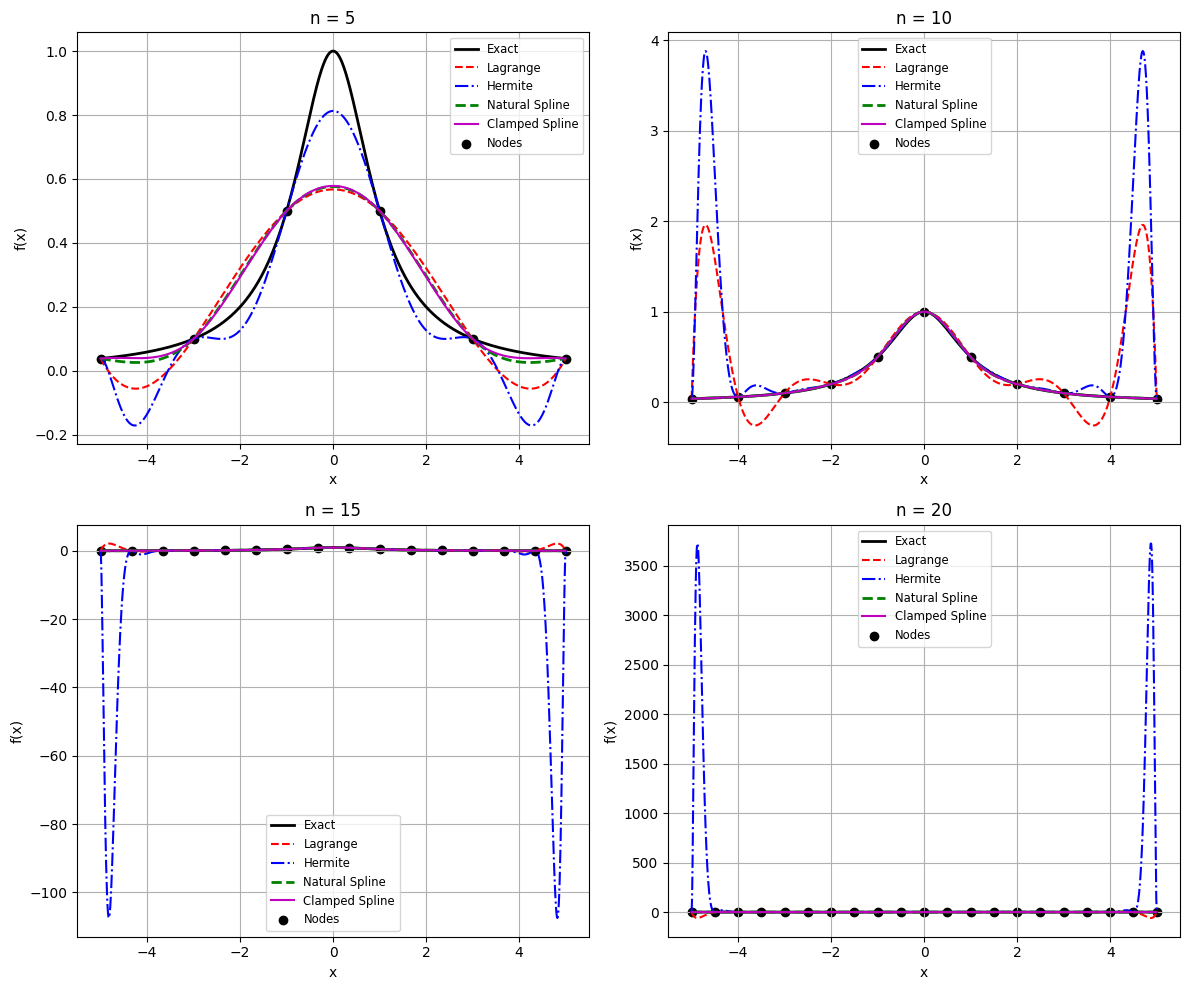

In [34]:
if __name__ == '__main__':
    driver()

# Problem 2

In [35]:
def chebyshev_nodes(a, b, n):
    i = np.arange(n+1)
    x_cheb = np.cos((2*i + 1)*np.pi/(2*(n+1)))
    return np.sort(0.5*(a + b) + 0.5*(b - a)*x_cheb)


 Errors for each iteration and method with chebyshev:
N is 5 | Lagrange is 0.26422547123038964 | Hermite is 0.1417742510685852 | Natural Spline is 0.21359517152009444 | Clamped Spline is 0.21301624257712592
N is 10 | Lagrange is 0.18271471906875192 | Hermite is 0.03338671968420137 | Natural Spline is 0.2017074708508575 | Clamped Spline is 0.20170563772450167
N is 15 | Lagrange is 0.0326109396632846 | Hermite is 0.0038953735509281717 | Natural Spline is 0.013626630579136823 | Clamped Spline is 0.013626646219240812
N is 20 | Lagrange is 0.025251967765200112 | Hermite is 0.0006377010533079597 | Natural Spline is 0.03878133344025514 | Clamped Spline is 0.03878133381110693


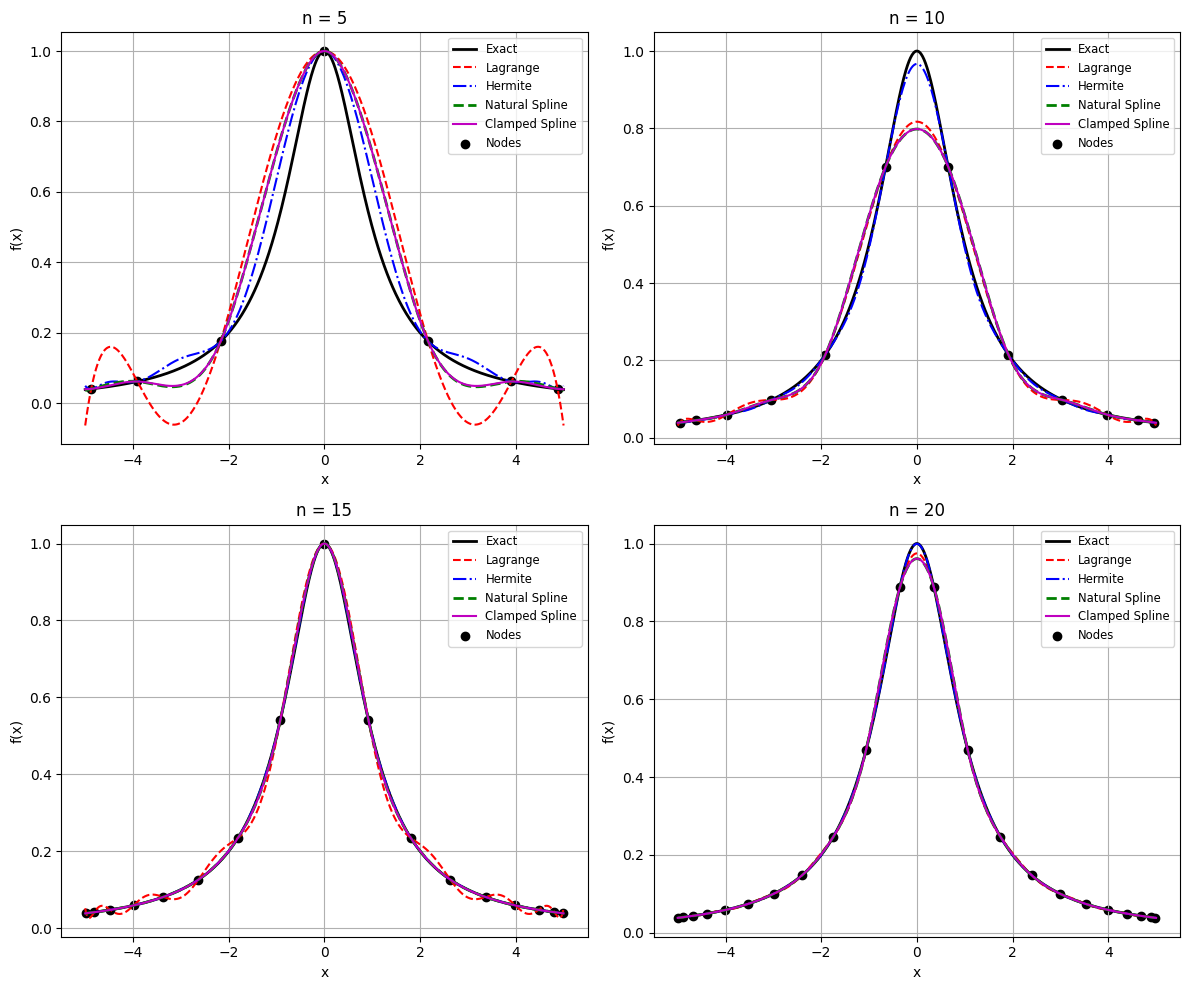

In [36]:
def driver():
    a, b = -5.0, 5.0
    xs = chebyshev_nodes(a, b, 1000+1)
    f_exact = f(xs)

    node_counts = [5, 10, 15, 20]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    print(" Errors for each iteration and method with chebyshev:")

    for idx, n in enumerate(node_counts):
        x_nodes = chebyshev_nodes(a, b, n+1)
        y_nodes = f(x_nodes)
        yp_nodes = fder(x_nodes)

        y_lagr = np.array([lagrange(x, x_nodes, y_nodes) for x in xs])
        y_herm = np.array([hermite(x, x_nodes, y_nodes, yp_nodes) for x in xs])

        M_nat, h_nat = cubic_spline(y_nodes, x_nodes, 'natural')
        y_nat = cubic_splineEval(xs, x_nodes, y_nodes, M_nat, h_nat)

        M_clamped, h_clamped = cubic_spline(y_nodes, x_nodes, 'clamped', fder(a), fder(b))
        y_clamped = cubic_splineEval(xs, x_nodes, y_nodes, M_clamped, h_clamped)

        lagrErr = np.max(np.abs(y_lagr - f_exact))
        hermErr = np.max(np.abs(y_herm - f_exact))
        natErr = np.max(np.abs(y_nat - f_exact))
        clampErr = np.max(np.abs(y_clamped - f_exact))

        print(f"N is {n:} | Lagrange is {lagrErr} | Hermite is {hermErr} | Natural Spline is {natErr} | Clamped Spline is {clampErr}")

        ax = axes[idx]
        ax.plot(xs, f_exact, 'k-', lw=2, label='Exact')
        ax.plot(xs, y_lagr, 'r--', label='Lagrange')
        ax.plot(xs, y_herm, 'b-.', label='Hermite')
        ax.plot(xs, y_nat, 'g--', lw=2, label='Natural Spline')
        ax.plot(xs, y_clamped, 'm-', label='Clamped Spline')
        ax.scatter(x_nodes, y_nodes, c='k', marker='o', label='Nodes')
        ax.set_title(f"n = {n}")
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.grid(True)
        ax.legend(fontsize='small')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    driver()